# Part I: Set Up

- Import Packages

In [53]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import os
from statistics import mean
from keras import backend as K
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten

- Initialize Variables

In [48]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 90
#os.chdir("/Users/youssefberrada/Dropbox (MIT)/15.961 Independant Study/Data")
os.chdir("/Users/michelcassard/Dropbox (MIT)/15.960 Independant Study/Data")
file = 'FX-5.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)

# Part 2: Data

- Load Data

In [29]:
def get_stock_data(stock_name, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    
    """
    df = xl.parse(stock_name)
    df.drop(['VOLUME'], 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)
     # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
  
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [30]:
df_GBP=get_stock_data("GBP Curncy",  ma=[50, 100, 200])

- Visualize the data

In [31]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                       Open    High     Low  Volume       Pct      50ma  \
Date                                                                      
2017-09-26 09:45:00  1.3442  1.3444  1.3433    4299 -0.000372  1.343802   
2017-09-26 09:50:00  1.3437  1.3447  1.3437    4947  0.000521  1.343738   
2017-09-26 09:55:00  1.3444  1.3446  1.3431    5552 -0.000818  1.343648   
2017-09-26 10:00:00  1.3433  1.3438  1.3431    7210  0.000074  1.343562   
2017-09-26 10:05:00  1.3434  1.3443  1.3432    5257  0.000447  1.343502   

                        100ma     200ma  Adj Close  
Date                                                
2017-09-26 09:45:00  1.346129  1.346931     1.3437  
2017-09-26 09:50:00  1.346099  1.346920     1.3444  
2017-09-26 09:55:00  1.346056  1.346904     1.3433  
2017-09-26 10:00:00  1.346018  1.346886     1.3434  
2017-09-26 10:05:00  1.345986  1.346872     1.3440  


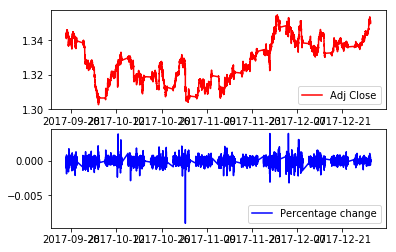

In [32]:
plot_stock(df_GBP)

- Training/Test Set

In [33]:
def load_data(stock,normalize,seq_len,split,ma):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    sequence_length = seq_len + 1 
    result_train = []
    result_test= []
    row = round(split * stock.shape[0]) 
    df_train=stock[0:row].copy()
    print ("Amount of training data = {}".format(df_train.shape[0]))
    df_test=stock[row:len(stock)].copy()
    print ("Amount of testing data = {}".format(df_test.shape[0]))

    
    if normalize:
        #Training
        min_max_scaler = preprocessing.MinMaxScaler()
        df_train['Open'] = min_max_scaler.fit_transform(df_train.Open.values.reshape(-1,1))
        df_train['High'] = min_max_scaler.fit_transform(df_train.High.values.reshape(-1,1))
        df_train['Low'] = min_max_scaler.fit_transform(df_train.Low.values.reshape(-1,1))
        df_train['Volume'] = min_max_scaler.fit_transform(df_train.Volume.values.reshape(-1,1))
        df_train['Adj Close'] = min_max_scaler.fit_transform(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Pct'] = min_max_scaler.fit_transform(df_train['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_train['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_train['{}ma'.format(moving)].values.reshape(-1,1))  
        #Test
        df_test['Open'] = min_max_scaler.fit_transform(df_test.Open.values.reshape(-1,1))
        df_test['High'] = min_max_scaler.fit_transform(df_test.High.values.reshape(-1,1))
        df_test['Low'] = min_max_scaler.fit_transform(df_test.Low.values.reshape(-1,1))
        df_test['Volume'] = min_max_scaler.fit_transform(df_test.Volume.values.reshape(-1,1))
        df_test['Adj Close'] = min_max_scaler.fit_transform(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Pct'] = min_max_scaler.fit_transform(df_test['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_test['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_test['{}ma'.format(moving)].values.reshape(-1,1))  
     
    #Training
    data_train = df_train.as_matrix()
    for index in range(len(data_train) - sequence_length): 
        result_train.append(data_train[index: index + sequence_length]) 
    train = np.array(result_train)
    X_train = train[:, :-1].copy() # all data until day m
    y_train = train[:, -1][:,-1].copy() # day m + 1 adjusted close price

    #Test
    data_test = df_test.as_matrix()
    for index in range(len(data_test) - sequence_length): 
        result_test.append(data_test[index: index + sequence_length]) 
    test = np.array(result_train)
    X_test = test[:, :-1].copy()
    y_test = test[:, -1][:,-1].copy()

    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [34]:
X_train, y_train, X_test, y_test = load_data(df_GBP,True,seq_len,split=0.7,ma=[50, 100, 200])

Amount of features = 9
Amount of training data = 13998
Amount of testing data = 5999


/Users/michelcassard/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# 3. Model

In [35]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    #model.add(Dense(neurons[0],activation="relu", input_shape=(shape[0], shape[1])))
    
    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [54]:
def build_model_CNN(shape, neurons, dropout, decay):
    model = Sequential()
    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(250))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('linear'))
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [55]:
model = build_model_CNN(shape, neurons, dropout, decay)

/Users/michelcassard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/Users/michelcassard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/Users/michelcassard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/Users/michelcassard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               64250     
__________

# 4. Results

- Model Fit

In [56]:
model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)

Train on 9782 samples, validate on 4193 samples
Epoch 1/90
9782/9782 [==============================] - 2s 157us/step - loss: 0.0300 - acc: 1.0223e-04 - val_loss: 0.0027 - val_acc: 2.3849e-04
Epoch 2/90
9782/9782 [==============================] - 0s 45us/step - loss: 0.0062 - acc: 1.0223e-04 - val_loss: 8.3929e-04 - val_acc: 2.3849e-04
Epoch 3/90
9782/9782 [==============================] - 0s 46us/step - loss: 0.0040 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 4/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0031 - acc: 1.0223e-04 - val_loss: 0.0017 - val_acc: 2.3849e-04
Epoch 5/90
9782/9782 [==============================] - 0s 44us/step - loss: 0.0025 - acc: 1.0223e-04 - val_loss: 0.0021 - val_acc: 2.3849e-04
Epoch 6/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0023 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 7/90
9782/9782 [==============================] - 1s 57us/step - loss: 0.0019 - acc

- Model Score

In [57]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [58]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00037 MSE (0.02 RMSE)
Test Score: 0.00037 MSE (0.02 RMSE)


(0.0003710565636182714, 0.0003710565636182714)

In [59]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    print(mean(percentage_diff))
    return p

In [60]:
p = percentage_difference(model, X_test, y_test)

-57.38379361472257


In [61]:
def plot_result_norm(stock_name, normalized_value_p, normalized_value_y_test):
    newp=normalized_value_p
    newy_test=normalized_value_y_test
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

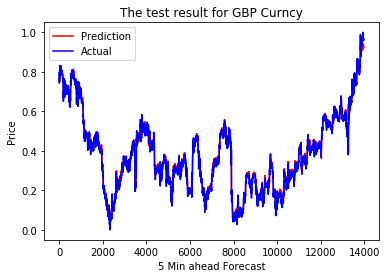

In [62]:
plot_result_norm("GBP Curncy", p, y_test)

In [69]:
def denormalize(stock_name, normalized_value,split=0.7,predict=True):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = xl.parse(stock_name)
    df.drop(['VOLUME'], 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)


    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    row = round(split * df.shape[0]) 
    if predict:
        df_p=df[0:row].copy()
    else:
        df_p=df[row:len(df)].copy()
    
    #return df.shape, p.shape
    mean_df=np.mean(df_p)
    std_df=np.std(df_p)
    new=normalized_value*mean_df+std_df
      
    return new

In [ ]:
def portfolio(currency_list,file = 'FX-5.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],split=0.7):
    i=0
    mini=99999999
    for currency in currency_list:
        df=get_stock_data(currency,  ma)
        X_train, y_train, X_test, y_test = load_data(df,True,seq_len,split,ma)
        model = build_model_CNN(shape, neurons, dropout, decay)
        model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)
        p = percentage_difference(model, X_test, y_test)
        newp = denormalize(currency, p,predict=True)
        if mini>p.size:
            mini=p.size
        if i==0:
            predict=p.copy()
        else:
            predict=np.hstack((predict[0:mini],p[0:mini]))
        i+=1
    return predict



In [ ]:
currency_list=[ 'GBP Curncy',
 'JPY Curncy',
 'EUR Curncy',
 'CAD Curncy',
 'NZD Curncy',
 'SEK Curncy',
 'AUD Curncy',
 'CHF Curncy',
 'NOK Curncy',
 'ZAR Curncy']
#currency_list=['JPY Curncy']
predictcur=portfolio(currency_list,file = 'FX-5.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 1,ma=[50, 100, 200],split=0.7)

In [168]:
# takes current_weights (n,1), previous_prices(n,t), next_price_pred(n,1) outputs updated_weighted (n,1)
def rebalance(current_weights, previous_prices, next_price_prediction, transaction_cost=0.0005):
    expected_return = np.log(next_price_prediction/previous_prices[:,-1])
    sharpe = expected_return/previous_prices.std(axis=1)
    w = sharpe/np.sum(sharpe)
    delta_w = (w - current_weights)/current_weights
    change = np.repeat(0,11)
    for i in range(len(current_weights)):
        if (delta_w[0,i-1]*(expected_return[0,i-1] - transaction_cost) > 0 ) :
            change[i-1] = w[0,i-1]
    total_change = (1 - np.sum(current_weights[change == 0]))
    upd_weights = change * total_change/np.sum(change[change!=0])
    upd_weights[upd_weights==0] = current_weights[upd_weights==0]
    return upd_weights

            
            
    
    
    

In [110]:
import pylab

import random

random.seed()
previous_prices = np.array([random.gauss(100, 1) for _ in range(11*100)])
previous_prices = np.reshape(past,(11,100))
#np.shape(previous_prices)
#np.shape(previous_prices[:,-1])
#len(current_weights)
current_weights = np.repeat(1/11,11)
#previous_prices = np.repeat(100,11)
next_price_prediction = np.array([[95,96,97,98,99,100,101,102,103,104,105]])


In [170]:
rebalance(current_weights, previous_prices, next_price_prediction, transaction_cost=0.0005)

array([-0.54545455, -0.27272727, -0.27272727,  0.09090909,  0.09090909,
        0.09090909,  0.09090909,  0.09090909,  0.27272727,  0.54545455,
        0.81818182])

In [171]:
def backtest(prices, predictions, initial_weights, length_past):
    


SyntaxError: unexpected EOF while parsing (<ipython-input-171-89c94c355f26>, line 2)

In [67]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p,predict=True)
    newy_test = denormalize(stock_name, normalized_value_y_test,predict=False)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

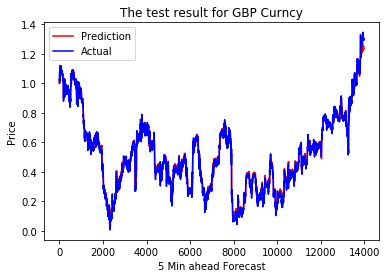

In [68]:
plot_result("GBP Curncy", p, y_test)

In [85]:
s=denormalize("GBP Curncy", y_test)

# WORKSPACE

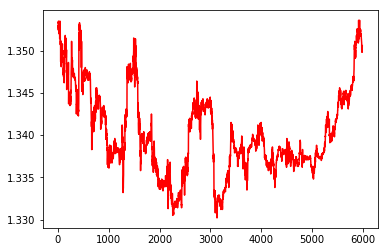

In [96]:
plt2.plot(s, color='red', label='Prediction')

In [ ]:
    stock=df_GBP
    split=0.7
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 
    result = []

    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)
    row = round(split * result.shape[0]) 
    print ("Amount of training data = {}".format(split * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split) * result.shape[0]))

    train = result[:int(row), :] 
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

In [99]:
    stock=df_GBP
    split=0.7
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 
    result = []

Amount of features = 9


In [100]:
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)
    row = round(split * result.shape[0]) 
    print ("Amount of training data = {}".format(split * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split) * result.shape[0]))



Amount of training data = 13981.8
Amount of testing data = 5992.200000000001


In [101]:
    train = result[:int(row), :] 
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price



In [106]:
X_train[1]

array([[0.78544061, 0.79961089, 0.78998073, 0.18487646, 0.73263144,
        0.80178064, 0.85258554, 0.87962225, 0.79885057],
       [0.79885057, 0.79766537, 0.77842004, 0.20749075, 0.6302588 ,
        0.79992581, 0.85168128, 0.8792669 , 0.77777778],
       [0.77777778, 0.78210117, 0.77842004, 0.26946511, 0.69849806,
        0.79815341, 0.85088217, 0.87889001, 0.77969349],
       [0.77969349, 0.79182879, 0.78034682, 0.19646395, 0.72694989,
        0.79691686, 0.85020924, 0.87857774, 0.79118774],
       [0.79118774, 0.78793774, 0.79190751, 0.14544163, 0.68143137,
        0.79568031, 0.84941013, 0.87825469, 0.78735632],
       [0.78735632, 0.79182879, 0.76300578, 0.23328225, 0.61885336,
        0.79419645, 0.84833764, 0.87782396, 0.76245211],
       [0.76245211, 0.75680934, 0.74566474, 0.26950249, 0.63586454,
        0.79250649, 0.84694972, 0.87728555, 0.74329502],
       [0.74329502, 0.75291829, 0.74759152, 0.17295257, 0.73269675,
        0.7911875 , 0.84564591, 0.87682252, 0.75670498],


In [107]:
y_train

array([0.74329502, 0.74329502, 0.74329502, ..., 0.96934866, 0.96743295,
       0.95785441])

In [109]:
 X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))

In [111]:
X_train[0]

array([[0.79501916, 0.79377432, 0.7822736 , 0.16065488, 0.66437187,
        0.80309962, 0.85321641, 0.87984838, 0.78544061],
       [0.78544061, 0.79961089, 0.78998073, 0.18487646, 0.73263144,
        0.80178064, 0.85258554, 0.87962225, 0.79885057],
       [0.79885057, 0.79766537, 0.77842004, 0.20749075, 0.6302588 ,
        0.79992581, 0.85168128, 0.8792669 , 0.77777778],
       [0.77777778, 0.78210117, 0.77842004, 0.26946511, 0.69849806,
        0.79815341, 0.85088217, 0.87889001, 0.77969349],
       [0.77969349, 0.79182879, 0.78034682, 0.19646395, 0.72694989,
        0.79691686, 0.85020924, 0.87857774, 0.79118774],
       [0.79118774, 0.78793774, 0.79190751, 0.14544163, 0.68143137,
        0.79568031, 0.84941013, 0.87825469, 0.78735632],
       [0.78735632, 0.79182879, 0.76300578, 0.23328225, 0.61885336,
        0.79419645, 0.84833764, 0.87782396, 0.76245211],
       [0.76245211, 0.75680934, 0.74566474, 0.26950249, 0.63586454,
        0.79250649, 0.84694972, 0.87728555, 0.74329502],


In [112]:
y_test

array([0.95402299, 0.95785441, 0.95785441, ..., 0.91187739, 0.90996169,
       0.91762452])

In [113]:
len(y_test)

5992

In [114]:
p = model.predict(X_test)

In [115]:
p

array([[0.95628846],
       [0.9523339 ],
       [0.94992006],
       ...,
       [0.9034717 ],
       [0.904866  ],
       [0.90557444]], dtype=float32)

In [116]:
len(p)

5992

In [117]:
min_max_scaler = preprocessing.MinMaxScaler()

new = min_max_scaler.inverse_transform(p)
      

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [125]:
len(X_train)

9987

In [126]:
len(df)

20197